# Deriving K_v

**Purpose**: Conduct experiments to derive K_v

## Data & imports

In [1]:
# MPL stuff
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12

from tol_colors import tol_cmap, tol_cset
cmap = tol_cset('vibrant')

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm_notebook


# Model stuff -- using baseline model
import sys
sys.path.append("../../models/new_baseline")

from model.model import *
from model.model_presets import BASELINE_MODEL, HIGH_MOVEMENT

def derive_mu_sigma_lognormal(mean, variance):
    sigma = np.sqrt(np.log(variance/(mean**2) + 1))
    mu    = np.log(mean) - .5*(sigma**2)
    return mu, sigma

# deriving ideal fig size
pt = 1./72.27
my_width = 426.79135*pt
golden = (1 + 5 ** 0.5) / 2
IDEAL_FIG_SIZE = (my_width, my_width/golden)

# NOTE: setting seed here.
np.random.seed(1389498)

In [2]:
NEW_BASELINE_MODEL = {
    "k" : 3,
    "timestep" : (2/24),
    "movement_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1, .001)), # high movement
    "sigma_h_arr" : np.array([19, 19, 19]),
    "sigma_v_arr" : np.array([.5, .5, .5]),
    "K_v_arr" : np.array([0,0,0]),
    "patch_densities" : np.array([.85, .08, .07]),
    "psi_v_arr" : np.array([.3, .3, .3]),
    "beta_hv_arr" : np.array([.33, .33, .33]),
    "beta_vh_arr" : np.array([.33, .33, .33]),
    "nu_v_arr" : np.array([.1, .1, .1]),
    "mu_v_arr" : np.array([1/14, 1/14, 1/14]),
    "num_households" : 2_351,
    "edge_prob" : .03,
    "num_agents" : 10_053,
    "initial_infect_proportion" : .005,
    "patch_init_infect_vector_prop_arr" : [.0, .0, .0],
    "nu_h_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1/5, .001)),
    "mu_h_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1/6, .001)),
    "total_time" : 200,
    "mosquito_timestep" : .005,
    "prob_adopt_itn": .0,
    "stay_home_chance": .0,
}

## Model runs

In [3]:
def gen_patch_start(start_val, modifier):
    return [int(a:=start_val*modifier), int(a*3), int(a*3.5)]

def select_keys_from_dict(d, keys):
    d_ = d.copy()

    for k in list(d.keys()):
        if k not in keys:
            del d_[k]
    
    return d_

In [4]:
base_val = 2700 # best so far is 2700; this is 10% higher

patch_K_v = {
    "-10": gen_patch_start(base_val, .9),
    "NA":  gen_patch_start(base_val, 1),
    "+10": gen_patch_start(base_val, 1.1),
}

In [5]:
patch_K_v

{'-10': [2430, 7290, 8505],
 'NA': [2700, 8100, 9450],
 '+10': [2970, 8910, 10395]}

In [6]:
num_runs = 20
fields_to_keep = ["num_infected", "total_infected"]
data = {n: None for n in patch_K_v}

for name, k_v in patch_K_v.items():
    cur_params = NEW_BASELINE_MODEL.copy()
    cur_params["K_v_arr"] = k_v
    
    df = [None] * num_runs
    
    for i in tqdm_notebook(range(num_runs)):
        m = BaselineModel(**cur_params)
        res, _ = m.run()
    
        df[i] = select_keys_from_dict(res, fields_to_keep)
        df[i]["amts"] = (np.sum([a.forest_worker for a in m.agents]),
                        np.sum([a.field_worker for a in m.agents]),
                        np.sum([not (a.forest_worker or a.field_worker) for a in m.agents]))
        data[name] = df

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "medium",
    "font.serif": "cmr10",  # cmr10 is part of Computer Modern Roman
    "axes.labelsize": 12,   # Corresponds to 12pt
    "font.size": 12,        # General font size
    "legend.fontsize": 12,  # Legend font size
    "xtick.labelsize": 12,  # X-axis tick label size
    "ytick.labelsize": 12,  # Y-axis tick label size
    'axes.formatter.use_mathtext': True,
})

In [8]:
plt.rcParams.update({
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
})

0: mean:94.20833333333334; median:102.0; mode:ModeResult(mode=array([53.25]), count=array([1]))
1: mean:100.9125; median:100.20833333333333; mode:ModeResult(mode=array([108.75]), count=array([2]))
2: mean:95.35; median:96.66666666666666; mode:ModeResult(mode=array([79.41666667]), count=array([1]))


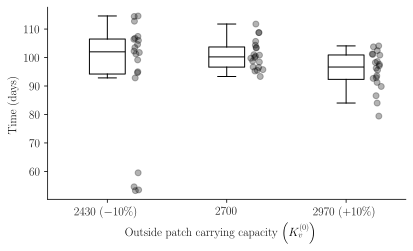

In [9]:
from scipy.stats import mode

plt.figure(figsize=IDEAL_FIG_SIZE)

run_infections = [[np.sum(list(data[j][i]["num_infected"].values()),axis=0) for i in range(num_runs)] for j in data]
run_inf_times  = [[np.argmax(run_infections[run][i])*m.timestep for i in range(num_runs)] for run in range(len(data))]

plt.boxplot(
    run_inf_times,
    showfliers=False,
    labels=[r"$2430$ $(-10\%)$", r"$2700$", r"$2970$ $(+10\%)$"],
    medianprops={"color": "black"}
)

for x, y in zip(range(len(data)), run_inf_times):
    print(f"{x}: mean:{np.mean(y)}; median:{np.median(y)}; mode:{mode(y, keepdims=True)}")
    plt.scatter([x+1.25+np.random.normal(0,.02) for _ in range(len(y))],
                y,
                alpha=.3,
                c='black')

plt.xlabel(r"Outside patch carrying capacity $\left(K_v^{(0)}\right)$")
plt.ylabel(r"Time (days)")
# plt.title(r"Distribution of epidemic peak timings for"+"\n"+r"different $K_v^{(0)}$ candidates")

plt.tight_layout()
plt.savefig("figs/k_v_candidates.pdf")

---

## Graveyard

-10: mean:97.37083333333334; median:103.0; mode:ModeResult(mode=array([56.5]), count=array([1]))
NA: mean:99.76666666666667; median:100.29166666666666; mode:ModeResult(mode=array([85.5]), count=array([1]))
+10: mean:89.425; median:93.33333333333333; mode:ModeResult(mode=array([88.75]), count=array([2]))


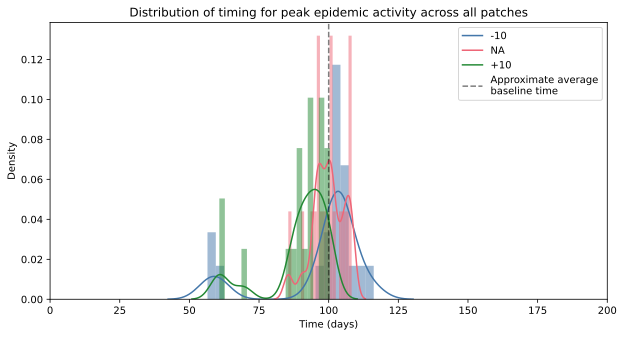

In [46]:
from tol_colors import tol_cset
cmap = tol_cset('bright')

from scipy.stats import mode

names = [
    "-10",
    "NA",
    "+10"
]

colors = cmap[:3]

# [
#     # "salmon",
#     "tomato",
#     "crimson",
#     "firebrick",
# ]

plt.figure(figsize=(10,5))

for (name, color) in zip(names, colors):
    peak_avgs = [np.sum(list(data[name][i]["num_infected"].values()),axis=0) for i in range(num_runs)]
    peak_avg_times = [np.argmax(peak_avgs[i])*m.timestep for i in range(num_runs)]
    print(f"{name}: mean:{np.mean(peak_avg_times)}; median:{np.median(peak_avg_times)}; mode:{mode(peak_avg_times, keepdims=True)}")

    plt.hist(
        peak_avg_times,
        alpha=.5,
        color=color,
        bins=20,
        density=True,
    )
    sns.kdeplot(
        peak_avg_times,
        bw_adjust=.5,
        color=color,
        label=name
    )

plt.axvline(100, color='black', ls='dashed', alpha=.5, label="Approximate average\nbaseline time")

plt.xlim(0, 200)
plt.xlabel("Time (days)")
plt.title("Distribution of timing for peak epidemic activity across all patches")
plt.legend()
plt.show()

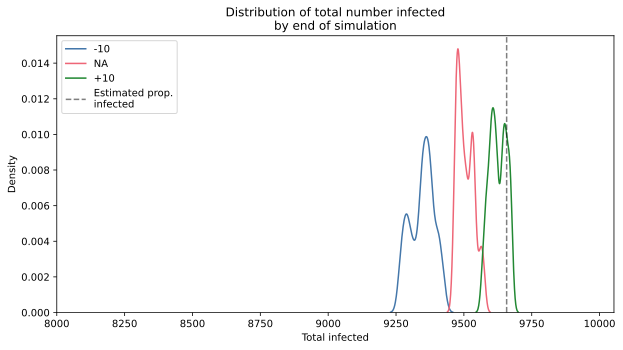

In [30]:
plt.figure(figsize=(10,5))

for (name, color) in zip(names, colors):
    sns.kdeplot([data[name][i]["total_infected"] for i in range(num_runs)],
                bw_adjust=.5,
                color=color,
                label=name)

# y_max = .017

plt.axvline((1441/1500)*10_053, color='black', ls='dashed', alpha=.5, label="Estimated prop.\ninfected")
# plt.fill_between([(1350/1500)*10_053, (1450/1500)*10_053], [y_max, y_max], alpha=.1, color='black')

plt.xlim(8_000, 10_053)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected\nby end of simulation")
plt.legend()
plt.show()

In [8]:
# import matplotlib
# matplotlib.rcParams['mathtext.fontset'] = 'cm'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.rcParams['font.size'] = 12

# # deriving ideal fig size
# pt = 1./72.27
# my_width = 426.79135*pt
# golden = (1 + 5 ** 0.5) / 2
# IDEAL_FIG_SIZE = (my_width, my_width/golden)

---

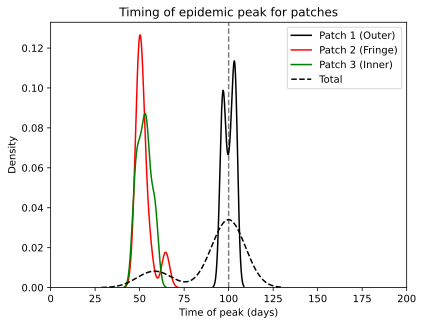

In [46]:
cur_name = "NA"

patch_names = ["Patch 1 (Outer)", "Patch 2 (Fringe)", "Patch 3 (Inner)"]
peak_infection_times = {patch: [np.argmax(data[cur_name][i]["num_infected"][patch])*m.timestep for i in range(len(data[cur_name]))] for patch in range(3)}
bw_adjust_amt = .75

for patch_id in range(3):
    sns.kdeplot(peak_infection_times[patch_id],
                bw_adjust=bw_adjust_amt,
                color=['black', 'red', 'green'][patch_id],
                label=patch_names[patch_id])

# TODO: checlk the "total" logic
peak_avgs = [np.sum(list(data[cur_name][i]["num_infected"].values()),axis=0) for i in range(num_runs)]
peak_avg_times = [np.argmax(peak_avgs[i])*m.timestep for i in range(num_runs)]
sns.kdeplot(
    peak_avg_times,
    bw_adjust=bw_adjust_amt,
    color='black',
    ls='dashed',
    label='Total'
)

plt.axvline(100, color='black', ls='dashed', alpha=.5)
plt.xlim(0,m.total_time)

plt.title("Timing of epidemic peak for patches")
plt.xlabel("Time of peak (days)")
plt.ylabel("Density")
plt.legend()
plt.show()

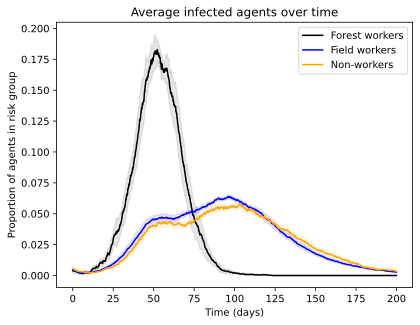

In [57]:
names = ["Forest workers", "Field workers", "Non-workers"]
palette = ["black", "blue", "orange", "green"]

for j, name, c in zip(range(num_runs), names, palette):
    avgs = np.mean([data[i]["agent_disease_counts"][j][2]/data[i]['amts'][j] for i in range(num_runs)],axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[i]["agent_disease_counts"][j][2]/data[i]['amts'][j] for i in range(num_runs)],axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average infected agents over time")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents in risk group")
plt.legend()
plt.savefig("img/avg_infect_agent", dpi=330)

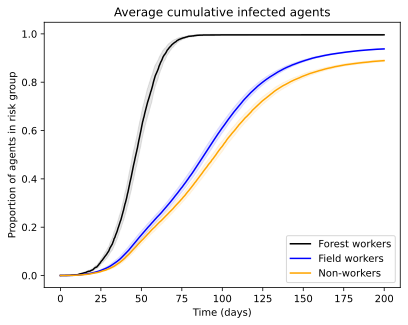

In [58]:
palette = ["black", "blue", "orange", "green"]

for j, name, c in zip(range(num_runs), names, palette):
    sums = np.cumsum([data[i]["agent_infected_unique"][j]/data[i]['amts'][j] for i in range(num_runs)],axis=1)
    avgs = np.mean(sums,axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std(sums,axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average cumulative infected agents")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents in risk group")
plt.legend()
plt.savefig("img/avg_cum_infect_agent", dpi=330)

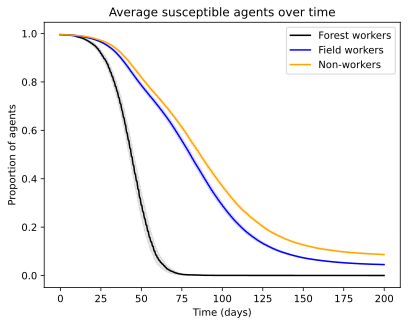

In [198]:
palette = ["black", "blue", "orange", "green"]

for j, name, c in zip(range(num_runs), names, palette):
    avgs = np.mean([data[i]["agent_disease_counts"][j][0]/data[i]['amts'][j] for i in range(num_runs)],axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[i]["agent_disease_counts"][j][0]/data[i]['amts'][j] for i in range(num_runs)],axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average susceptible agents over time")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents")
plt.legend()
plt.show()

In [199]:
data[0].keys()

dict_keys(['time', 'lambda_hj', 'lambda_v', 'num_infected', 'agent_disease_counts', 'agent_infected_unique', 'patch_values', 'infection_records', 'time_in_household', 'time_in_field', 'temperature', 'num_movements', 'total_exposed', 'total_infected', 'total_recovered', 'total_time_in_state', 'patch_sei', 'node_seir', 'amts'])

In [200]:
import pickle as pkl

In [201]:
with open("run_+20pc.pkl", 'wb') as f:
    pkl.dump([data[i]["total_infected"] for i in range(num_runs)], f, protocol=pkl.HIGHEST_PROTOCOL)

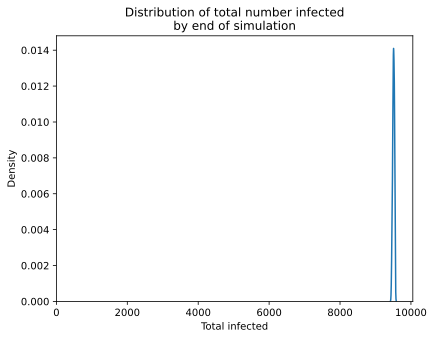

In [202]:
sns.kdeplot([data[i]["total_infected"] for i in range(num_runs)], bw_adjust=1)

plt.xlim(0, m.num_agents)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected\nby end of simulation")
plt.show()

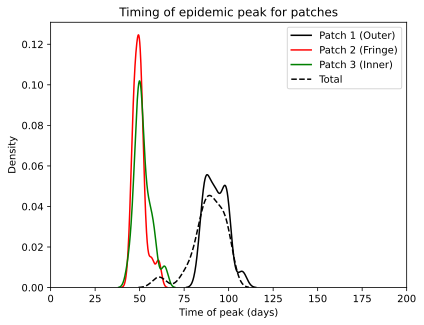

In [203]:
patch_names = ["Patch 1 (Outer)", "Patch 2 (Fringe)", "Patch 3 (Inner)"]
peak_infection_times = {patch: [np.argmax(data[i]["num_infected"][patch])*m.timestep for i in range(len(data))] for patch in range(3)}
bw_adjust_amt = .75

for patch_id in range(3):
    sns.kdeplot(peak_infection_times[patch_id],
                bw_adjust=bw_adjust_amt,
                color=['black', 'red', 'green'][patch_id],
                label=patch_names[patch_id])

peak_avgs = [np.sum(list(data[i]["num_infected"].values()),axis=0) for i in range(num_runs)]
peak_avg_times = [np.argmax(peak_avgs[i])*m.timestep for i in range(num_runs)]
sns.kdeplot(
    peak_avg_times,
    bw_adjust=bw_adjust_amt,
    color='black',
    ls='dashed',
    label='Total'
)

plt.xlim(0,m.total_time)

plt.title("Timing of epidemic peak for patches")
plt.xlabel("Time of peak (days)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [16]:
files = [
    # "run_-10pc.pkl",
    "run_2500-7400-8100.pkl",
    "run_+10pc.pkl",
    "run_+20pc.pkl"
]

names = [
    # "-20%",
    "-10%",
    "base",
    "+10%"
]

colors = [
    # "salmon",
    "tomato",
    "crimson",
    "firebrick",
]

data = {name : None for name in names}

for filename, name in zip(files, names):
    with open(filename, 'rb') as f:
        data[name] = pickle.load(f)

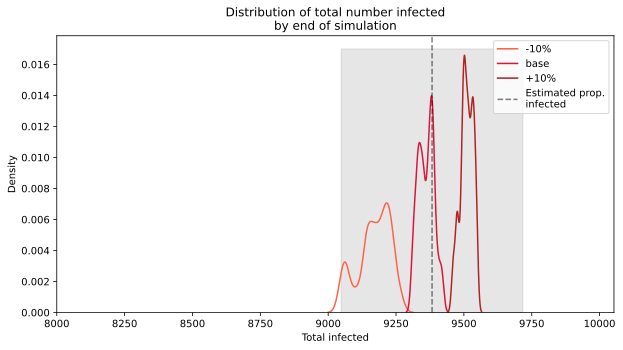

In [17]:
plt.figure(figsize=(10,5))

for (name, color) in zip(names, colors):
    sns.kdeplot(data[name],
                bw_adjust=.5,
                color=color,
                label=name)

y_max = .017

plt.axvline((1400/1500)*10_053, color='black', ls='dashed', alpha=.5, label="Estimated prop.\ninfected")
plt.fill_between([(1350/1500)*10_053, (1450/1500)*10_053], [y_max, y_max], alpha=.1, color='black')

plt.xlim(8_000, 10_053)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected\nby end of simulation")
plt.legend()
plt.show()